# Sleep scoring

Load packages

In [1]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
from scipy import stats
from itertools import groupby

%matplotlib widget
from IPython.display import display
from ipyfilechooser import FileChooser
import os
from ephyviewer import mkQApp, MainViewer, TraceViewer

Load downsampled recordings

In [2]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"


# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>OpenEphys Folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

In [3]:
folder_base = Path(dpath)

filename0 = folder_base / f'LFPwake0_AB.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
filenamePKL = folder_base / f'EMGframeBoolean_AB.pkl'

All = np.load(filename2, mmap_mode= 'r')
All0 = np.load(filename0, mmap_mode= 'r')
Bool = pd.read_pickle(filenamePKL)

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
allchannels = pd.read_excel(Channels)

mice = os.path.basename(os.path.dirname(os.path.dirname(folder_base)))


Associate channels to brain areas

In [17]:
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
PFC  =  All[:, PFCch1]-All[:, PFCch2] 

S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
S1  =  All[:, S1ch1]-All[:, S1ch2] 

ThetaCh = CA1
Beta1Ch = PFC
Beta2Ch = S1

EMGch=int(allchannels[mice][3])
EMG  =  All[:, EMGch]

Visualise to determine what channel/stereochannel to use to extract muscular activity, delta, theta, beta and maybe index of higher frequency

In [5]:
combined = np.stack([S1, PFC, CA1/2, EMG], axis=1)

app = mkQApp()

sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#9955aa'
view1.by_channel_params['ch3', 'color'] = '#999999'

view1.params['scale_mode'] = 'same_for_all'
view1.auto_scale()

#Run
win.show()
app.exec_()

0

## Build vigilance state scoring vector
[we use here liberal boolean for wake detection]

    ### 0 = wake
    ### 1 = REM
    ### >1 = NREM

    

Set all sleep at 1 and wake at 0

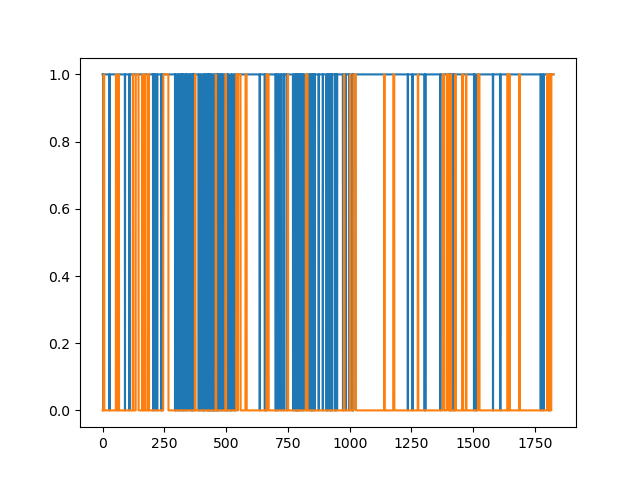

In [6]:
ScoringVectorLength = len(EMG)
ScoringVector = np.zeros((ScoringVectorLength))
WakeStatus = np.zeros((ScoringVectorLength))
WakeStatusCons = np.zeros((ScoringVectorLength))
EMGStatusBoolLib = Bool.BooleanLiberal
EMGStatusBoolCons = Bool.BooleanConservative
WakeStatus[EMGStatusBoolLib] = 1
WakeStatusCons[EMGStatusBoolCons] = 1

fs = 1000
times = np.arange(0, EMG.size/fs, 1./fs)
plt.close()
plt.plot(times, WakeStatusCons)
plt.plot(times, WakeStatus)
plt.show()

Extract REM and set NREM at 2

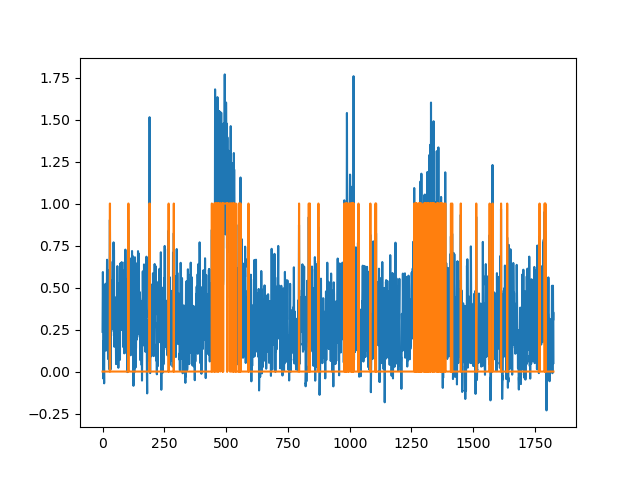

In [18]:
# Filtre parameter:
f_lowcut = 5.
f_hicut = 9.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')

#ThetaCh[EMGStatusBoolLib]=0

filt_Theta = signal.filtfilt(b, a, ThetaCh)

# Parameter and computation of CWT
w = 30.
freq = np.linspace(5, 9, 8)
widths = w*fs / (2*freq*np.pi)
ThetaCWT = signal.cwt(filt_Theta, signal.morlet2, widths, w=w)

# Projection calculation
absThetaCWT = np.absolute(ThetaCWT)

zabsThetaCWT = stats.zscore(absThetaCWT, axis=None)

proj_ThetaCWT = np.max(zabsThetaCWT, axis = 0)/8
sdproj_ThetaCWT = np.std(proj_ThetaCWT)
meanproj_ThetaCWT = np.mean(proj_ThetaCWT)

numpnts = EMG.size
ThetaStatus = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_ThetaCWT[ind]>(meanproj_ThetaCWT+1.4*sdproj_ThetaCWT):
        ThetaStatus[ind] = 1

plt.close()
plt.plot(times, proj_ThetaCWT*2)
plt.plot(times, ThetaStatus)
plt.show()

Extract beta 

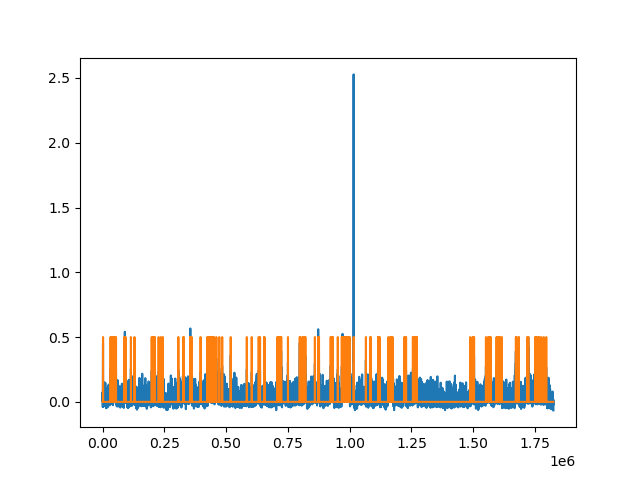

In [8]:
# Filtre parameter:
f_lowcut = 10.
f_hicut = 18.
fs = 1000
nyq = 0.5 * fs
N = 4                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_Beta1 = signal.filtfilt(b, a, Beta1Ch)
filt_Beta2 = signal.filtfilt(b, a, Beta2Ch)

# Parameter and computation of CWT
w = 10.
freq = np.linspace(10, 18, 16)
widths = w*fs / (2*freq*np.pi)
Beta1CWT = signal.cwt(filt_Beta1, signal.morlet2, widths, w=w)
Beta2CWT = signal.cwt(filt_Beta2, signal.morlet2, widths, w=w)

# Projection calculation
absBeta1CWT = np.absolute(Beta1CWT)
absBeta2CWT = np.absolute(Beta2CWT)
from scipy import stats

zabsBeta1CWT = stats.zscore(absBeta1CWT, axis=None)
zabsBeta2CWT = stats.zscore(absBeta2CWT, axis=None)

proj_Beta1CWT = np.max(zabsBeta1CWT, axis = 0)/16
proj_Beta2CWT = np.max(zabsBeta2CWT, axis = 0)/16
meanproj_Beta1CWT = np.mean(zabsBeta1CWT)
meanproj_Beta2CWT = np.mean(zabsBeta2CWT)
sdproj_Beta1CWT = np.std(proj_Beta1CWT)
sdproj_Beta2CWT = np.std(proj_Beta2CWT)

numpnts = EMG.size
Beta1Status = np.zeros(numpnts)
Beta2Status = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_Beta1CWT[ind]>(meanproj_Beta1CWT+3*sdproj_Beta1CWT):
        Beta1Status[ind] = 1
    if proj_Beta2CWT[ind]>(meanproj_Beta2CWT+3*sdproj_Beta2CWT):
        Beta2Status[ind] = 1


plt.close()
plt.plot(proj_Beta2CWT)
plt.plot(Beta2Status/2)
plt.show()

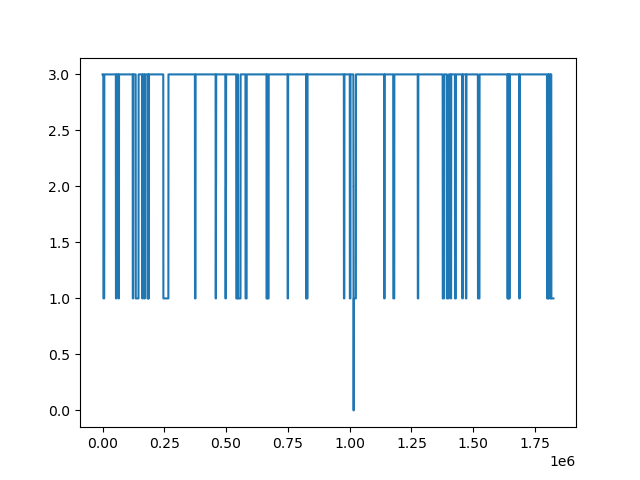

In [10]:
ScoringVector = np.ones((ScoringVectorLength))
for ind in range(numpnts):
    if ThetaStatus[ind]>0:
        ScoringVector[ind] = 2
    if Beta1Status[ind]>0:
        ScoringVector[ind] = 0
    if WakeStatus[ind]==0:
        ScoringVector[ind] = 3

plt.close()
plt.plot(ScoringVector)
plt.show()

Reduce bins

363


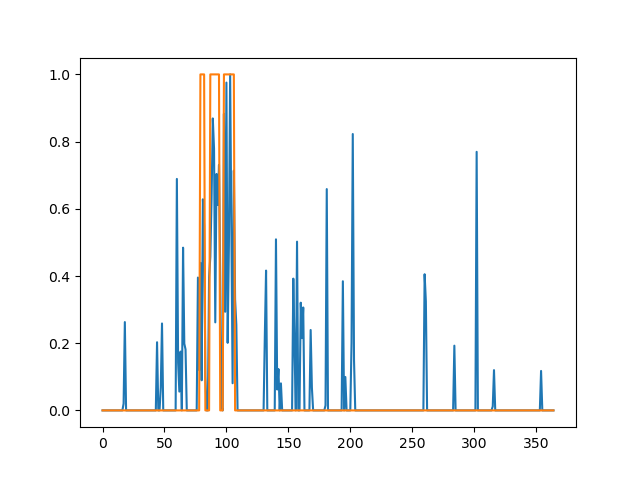

In [11]:
input_arr = ThetaStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arr, split_arr[1:])

dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

plt.close()
plt.plot(dwnsmpl_arrT)

for i in range(len(dwnsmpl_arrT)):
    if dwnsmpl_arrT[i]<0.4: #0.25
        dwnsmpl_arrT[i] = 0
    else:
        dwnsmpl_arrT[i] = 1  

for i in range(len(dwnsmpl_arrT)-3):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break          
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+2]>0):
        dwnsmpl_arrT[i+1]=1
    elif (dwnsmpl_arrT[i]>0 and dwnsmpl_arrT[i+3]>0):
        dwnsmpl_arrT[i+1]=1
        dwnsmpl_arrT[i+2]=1

for i in range(len(dwnsmpl_arrT)):
    if i > (len(dwnsmpl_arrT)-3):
        print(i)
        break
    elif (dwnsmpl_arrT[i]<1 and dwnsmpl_arrT[i+1]>0 and dwnsmpl_arrT[i+2]<1):
        dwnsmpl_arrT[i+1]=0

plt.plot(dwnsmpl_arrT)
plt.show()


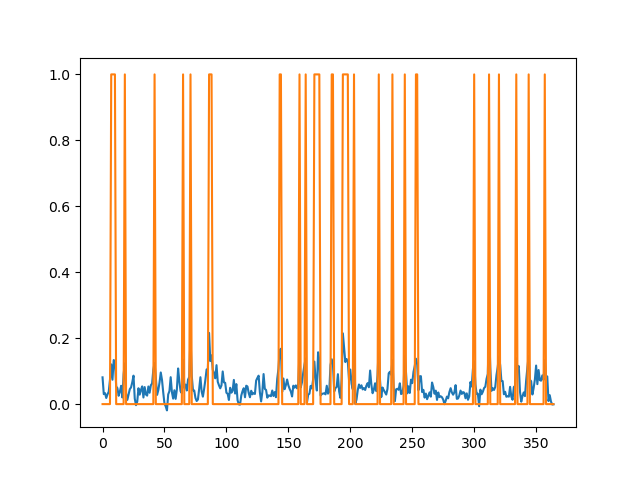

In [12]:
input_arr1 = proj_Beta1CWT
input_arr2 = proj_Beta2CWT

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr1 = np.linspace(0, len(input_arr1), num=R+1, dtype=int)
split_arr2 = np.linspace(0, len(input_arr2), num=R+1, dtype=int)

dwnsmpl_subarr1 = np.split(input_arr1, split_arr1[1:])
dwnsmpl_subarr2 = np.split(input_arr2, split_arr2[1:])

dwnsmpl_arr1B = np.array( list( np.mean(item) for item in dwnsmpl_subarr1[:-1] ) )
dwnsmpl_arr2B = np.array( list( np.mean(item) for item in dwnsmpl_subarr2[:-1] ) )

plt.close()
plt.plot(dwnsmpl_arr2B)

for i in range(len(dwnsmpl_arr1B)):
    if dwnsmpl_arr1B[i]<0.12: # arbitrary set
        dwnsmpl_arr1B[i] = 0
    else:
        dwnsmpl_arr1B[i] = 1  

for i in range(len(dwnsmpl_arr1B)-3):
    if i > (len(dwnsmpl_arr1B)-3):
        break                 
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+2]>0):
        dwnsmpl_arr1B[i+1]=1
    elif (dwnsmpl_arr1B[i]>0 and dwnsmpl_arr1B[i+3]>0):
        dwnsmpl_arr1B[i+1]=1
        dwnsmpl_arr1B[i+2]=1

for i in range(len(dwnsmpl_arr2B)):
    if dwnsmpl_arr2B[i]<0.12: # arbitrary set
        dwnsmpl_arr2B[i] = 0
    else:
        dwnsmpl_arr2B[i] = 1  

for i in range(len(dwnsmpl_arr2B)-3):          
    if (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+2]>0):
        dwnsmpl_arr2B[i+1]=1
    elif (dwnsmpl_arr2B[i]>0 and dwnsmpl_arr2B[i+3]>0):
        dwnsmpl_arr2B[i+1]=1
        dwnsmpl_arr2B[i+2]=1

plt.plot(dwnsmpl_arr2B)
plt.show()

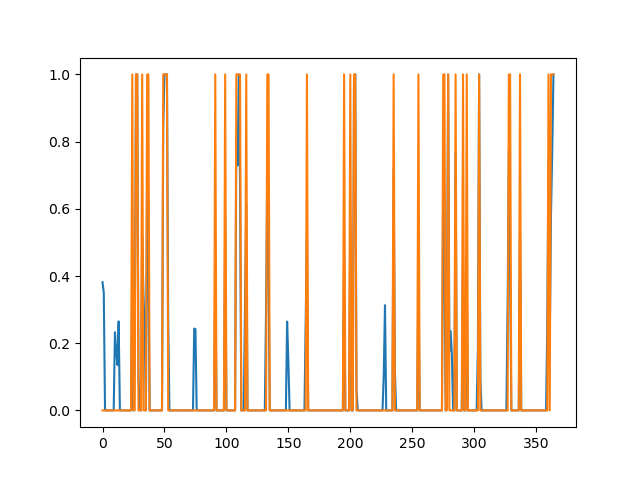

In [13]:
input_arrW = WakeStatus

R = round(ScoringVectorLength/5000) # 5 sec bins

split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)

dwnsmpl_subarr = np.split(input_arrW, split_arr[1:])

dwnsmpl_arrW = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
plt.close()
plt.plot(dwnsmpl_arrW)

for i in range(len(dwnsmpl_arrW)):
    if dwnsmpl_arrW[i]<0.4: # arbitrary set
        dwnsmpl_arrW[i] = 0
    else:
        dwnsmpl_arrW[i] = 1 

plt.plot(dwnsmpl_arrW)
plt.show()

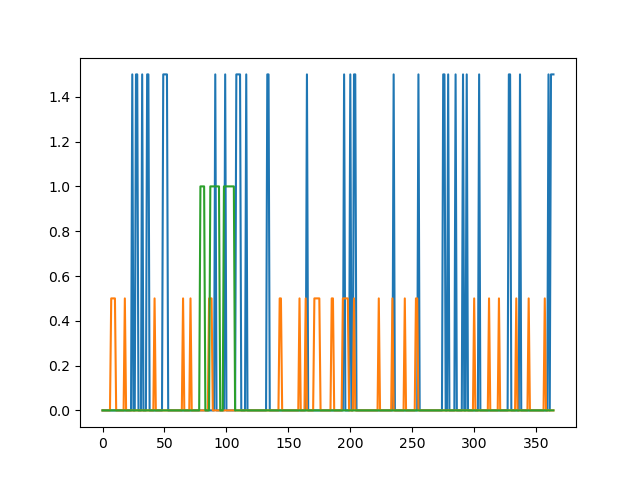

In [14]:
dwnsmpl_arrT = dwnsmpl_arrT * 1
dwnsmpl_arrW = dwnsmpl_arrW * 1.5
dwnsmpl_arr1B = dwnsmpl_arr1B * 0.5
dwnsmpl_arr2B = dwnsmpl_arr2B * 0.5

plt.close()
plt.plot(dwnsmpl_arrW)
plt.plot(dwnsmpl_arr2B)
plt.plot(dwnsmpl_arrT)
plt.show()

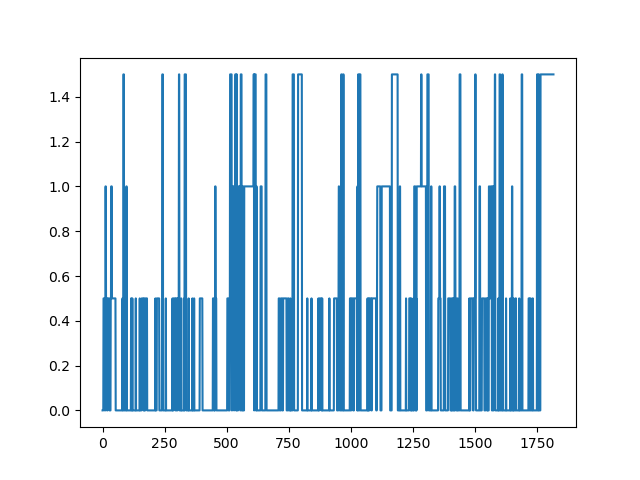

In [59]:
ScoringVectorS = np.zeros((len(dwnsmpl_arrW)))
for ind in range(len(dwnsmpl_arrW)): #0 =NREM
    if dwnsmpl_arr2B[ind]>0:
        ScoringVectorS[ind] = 0.5 #N2
    if dwnsmpl_arrT[ind]>0:
        ScoringVectorS[ind] = 1 #REM
    if dwnsmpl_arrW[ind]>0:
        ScoringVectorS[ind] = 1.5 #Wake


plt.close()
plt.plot(ScoringVectorS)
plt.show()

In [18]:
array=ScoringVectorS
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()        
substates_start =np.append([0],substates_end[:-1]) #substates_start =np.append([1],substates_end+1) create 1 second gap
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates = pd.DataFrame(list(zip(substates_identity, substates_duration, substates_start, substates_end)), columns=['Identity', 'Duration', 'Start','End'])


In [20]:
substates

,Identity,Duration,Start,End
0,NREM,3,0,3
1,N2,1,3,4
2,NREM,3,4,7
3,N2,3,7,10
4,NREM,7,10,17
...,...,...,...,...
76,N2,1,345,346
77,NREM,5,346,351
78,Wake,1,351,352
79,NREM,1,352,353


In [21]:
ScoringVectorS2=ScoringVectorS.copy()
for index in substates.index[substates.Identity == 'REM'].tolist():
    if substates.Identity[index+2]=='REM':
        start=substates.Start[index+1]
        end=substates.End[index+1]
        ScoringVectorS2[start:end]=1


In [22]:
array=ScoringVectorS2
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()        
substates_start =np.append([0],substates_end[:-1]) #substates_start =np.append([1],substates_end+1) create 1 second gap
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates2 = pd.DataFrame(list(zip(substates_identity, substates_duration, substates_start, substates_end)), columns=['Identity', 'Duration', 'Start','End'])


In [23]:
substates2

,Identity,Duration,Start,End
0,NREM,3,0,3
1,N2,1,3,4
2,NREM,3,4,7
3,N2,3,7,10
4,NREM,7,10,17
...,...,...,...,...
72,N2,1,345,346
73,NREM,5,346,351
74,Wake,1,351,352
75,NREM,1,352,353


In [ ]:
for i in range(len(ScoringVectorS)):
    if i > (len(ScoringVectorS)-4):
        break       
    elif not ScoringVectorS[i]==1.5 and ScoringVectorS[i+1]==1.5 and not ScoringVectorS[i+2]==1.5:
        ScoringVectorS[i+1]=ScoringVectorS[i] # need at least 2consecutive bins / 10sec of Wake
    elif (ScoringVectorS[i]==0.5 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=0.5
    elif (ScoringVectorS[i]==1 and ScoringVectorS[i+1]==0):
        ScoringVectorS[i+1]=1 #can't be NREM after REM
    elif (ScoringVectorS[i]==1 and ScoringVectorS[i+1]==0.5):
        ScoringVectorS[i+1]=1 #can't be NREM after REM

plt.close()
plt.plot(ScoringVectorS)
plt.show()

In [ ]:
for i in range(len(ScoringVectorS)):
    if i > (len(ScoringVectorS)-4):
        print(i)
        break          
    elif (ScoringVectorS[i]==0.5 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=0.5
    elif (ScoringVectorS[i]==1 and ScoringVectorS[i+1]==0 and ScoringVectorS[i+2]>0):
        ScoringVectorS[i+1]=1
    elif (ScoringVectorS[i]==1.5 and ScoringVectorS[i+1]<1.5 and (ScoringVectorS[i+2]==1.5 or ScoringVectorS[i+3]==1.5)):
        ScoringVectorS[i+1]=1.5

plt.close()
plt.plot(ScoringVectorS)
plt.show()

In [60]:
filenameOut = folder_base / f'ScoredSleep_AB.npy'
np.save(filenameOut, ScoringVectorS)

